In [2]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import copy
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


In [3]:
numb_batch = 64

T = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to mnist_data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist_data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



In [4]:
def create_lenet():
    model = nn.Sequential(
                            nn.Conv2d(1, 6, 5, padding=2),
                            nn.ReLU(),
                            nn.AvgPool2d(2, stride=2),
                            nn.Conv2d(6, 16, 5, padding=0),
                            nn.ReLU(),
                            nn.AvgPool2d(2, stride=2),
                            nn.Flatten(),
                            nn.Linear(400, 120),
                            nn.ReLU(),
                            nn.Linear(120, 84),
                            nn.ReLU(),
                            nn.Linear(84, 10)
                        )
    return model

In [5]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total


In [6]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device


device(type='cuda', index=0)

Saving Best Model with Accuracy:  95.45999908447266
Epoch: 1 Accuracy : 95.45999908447266 %
Saving Best Model with Accuracy:  96.20999908447266
Epoch: 2 Accuracy : 96.20999908447266 %
Saving Best Model with Accuracy:  97.75
Epoch: 3 Accuracy : 97.75 %
Saving Best Model with Accuracy:  98.22000122070312
Epoch: 4 Accuracy : 98.22000122070312 %
Saving Best Model with Accuracy:  98.48999786376953
Epoch: 5 Accuracy : 98.48999786376953 %
Saving Best Model with Accuracy:  98.61000061035156
Epoch: 6 Accuracy : 98.61000061035156 %
Saving Best Model with Accuracy:  98.73999786376953
Epoch: 7 Accuracy : 98.73999786376953 %
Epoch: 8 Accuracy : 98.55000305175781 %
Epoch: 9 Accuracy : 98.7300033569336 %
Epoch: 10 Accuracy : 98.58000183105469 %
Saving Best Model with Accuracy:  98.80999755859375
Epoch: 11 Accuracy : 98.80999755859375 %
Epoch: 12 Accuracy : 98.69000244140625 %
Epoch: 13 Accuracy : 98.69000244140625 %
Epoch: 14 Accuracy : 98.66999816894531 %
Saving Best Model with Accuracy:  98.8799972

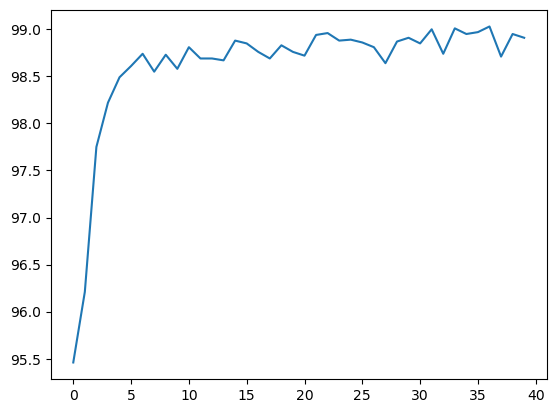

In [8]:
lenet = train(40, device=device)


In [9]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

y_pred, y_true = predict_dl(lenet, val_dl)
